<h1>Insurance EDA</h1>

In [18]:
# Importing Necessary Libraries

%matplotlib agg
%matplotlib agg

import io
import math
import base64
import operator
import statistics

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib.ticker as ticker
from IPython.display import HTML, Image

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [6]:
# Loading Insurance Data

insurance = pd.read_csv("insurance.csv")
train_y = insurance['charges'].values

In [7]:
# Taking an Initial Look at Data

print(insurance.shape)
print(insurance.columns)
print(insurance[insurance.isnull().any(axis=1)])

(1338, 7)
Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')
Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []


<h3>Feature Analysis (Individual)</h3>

This section is primarily meant to explore how each of the given features relate solely to the target column, as well as to determine which of the overall features provide the most useful information. Not only this, I will also explore ways they can be improved in order to divulge even more information and assess their contribution to the model generated later in this EDA.

In [8]:
# Looking at Dataset Shape/Head

print('We have {} rows and {} columns.'.format(insurance.shape[0], insurance.shape[1]))
print(insurance.head(2))

We have 1338 rows and 7 columns.
   age     sex    bmi  children smoker     region     charges
0   19  female  27.90         0    yes  southwest  16884.9240
1   18    male  33.77         1     no  southeast   1725.5523


From a cursory glance at both the Overview page on Kaggle as well as the Github page from where the data was retrieved, the dataset is one of many provided in "Machine Learning with R", a book by Brett Lantz intended to provide ML challenges for the reader. It consists of 1,338 rows and 7 columns/features, each of which is explained in detail below:

<ul>
    <li><b>Age (int64)</b>: The age of the patient or primary beneficiary</li>
    <li><b>Sex (object)</b>: The gender of the patient or primary beneficiary</li>
    <li><b>BMI (float64)</b>: The BMI, or "Body Mass Index" of the patient or primary beneficiary, and is calculated through the formula: "BMI = kg/m^2"</li>
    <li><b>Children (int64)</b>: The number of children that the patient or primary beneficiary claim as dependents</li>
    <li><b>Smoker (object)</b>: Whether or not the patient or primary beneficiary happens to smoke</li>
    <li><b>Region (object)</b>: The region of the US (NE, SE, SW, NW) that the patient or primary beneficiary lives in</li>
    <li><b>Charges (float64)</b>: The medical costs billed by the patient or primary beneficiary's insurance</li>
</ul>

In [9]:
# Encode Categorical Columns

sex_mapping = {"male": 0, "female": 1, 0: 0, 1: 1}
smoker_mapping = {"no": 0, "yes": 1, 0: 0, 1: 1}
region_mapping = {"southeast": 0, "southwest": 1, "northwest": 2, "northeast": 3, 
                  0: 0, 1: 1, 2: 2, 3: 3}

insurance['sex'] = insurance['sex'].map(lambda x: sex_mapping[x])
insurance['smoker'] = insurance['smoker'].map(lambda x: smoker_mapping[x])
insurance['region'] = insurance['region'].map(lambda x: region_mapping[x])

Given the information above, we are able to see that we have six different columns to work with, each of which playing a role in the insurance's final charge, while "charges" refers to the labeled target. At first glance, it seems clear that the age, BMI, and "smoker" columns will perhaps provide the most insight, and as such it'll probably be useful to go and explore/investigate those first. Besides this, there also is not any NaN values present in any of the columns in the dataset

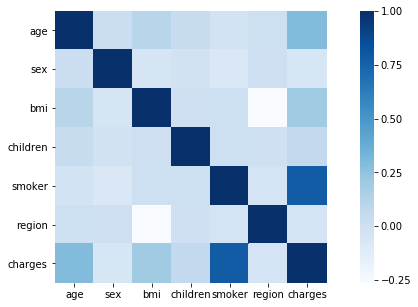

In [10]:
# Assess Correlation of Data
%matplotlib inline

f = plt.figure(figsize=(12, 5))
correlation = insurance.corr()
graph = sns.heatmap(correlation, mask=np.zeros_like(correlation, dtype=np.bool), cmap="Blues", square=True)

This heatmap goes to show that, as expected, the age, BMI, and "smoker" columns are perhaps the most indicative of a patient's future medical costs. However, it's interesting how much a patient being a smoker affects their insurance charges overall, as I would have expected either BMI or age to have more of an effect. In order to explore these correlations further, we'll separate each column in the dataset and look further into each individually, followed by a section of feature engineering and extensive regression model.

In [11]:
# Exploring "Age" Column in Dataset

age_counts = insurance['age'].value_counts()
age_dict = dict(age_counts)

print('Most Common Age:', max(age_counts.iteritems(), key=operator.itemgetter(1))[0])

Most Common Age: 18


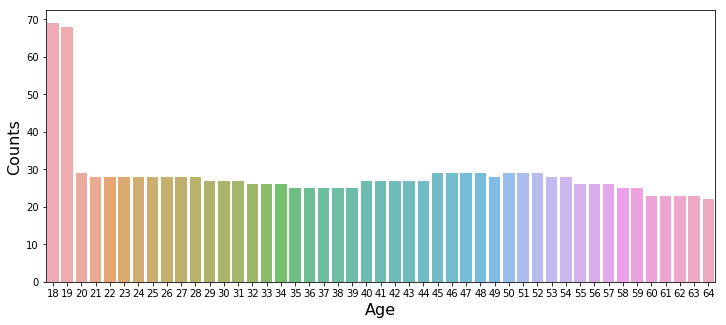

In [12]:
# Graphing "Age" Counts in Dataset
%matplotlib inline

f = plt.figure(figsize=(12, 5))
sns.barplot(age_counts.index, age_counts.values, alpha=0.8)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Counts', fontsize=16)
graph = plt.show()

Here, we can see the overall distribution of ages in the dataset. Although most of the data seems evenly distributed, there's quite a few more 18-19-year-olds whom are represented. As such, the next thing to look into would have to be the average insurance charges wrt. age to see if there is an overall correlation between age and charge. I have a hunch that there will be an uphill trend as an individual gets older.

In [13]:
# Calculate "Charge" wrt. "Age"

charge_dict = {}
for index, row in insurance.iterrows():
    if row['age'] in charge_dict:
        list.append(charge_dict[row['age']], row['charges'])
    else:
        charge_dict[row['age']] = [row['charges']]

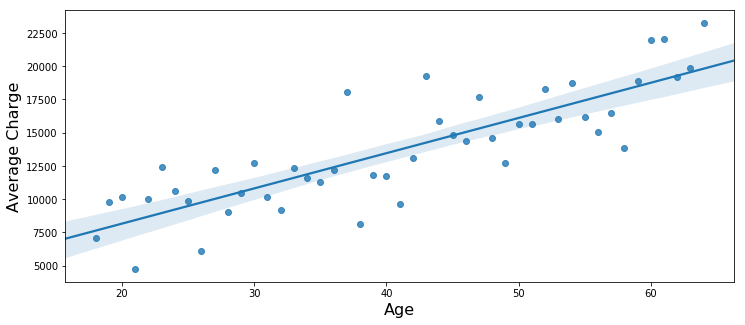

In [14]:
# Graphing Average "Charge" wrt. "Age"
%matplotlib inline

averages = []
for key, value in charge_dict.items():
    list.append(averages, [key, sum(value) / len(value)])

x_values = [x[0] for x in averages]
y_values = [x[1] for x in averages]

f = plt.figure(figsize=(12, 5))
sns.regplot(x_values, y_values)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Average Charge', fontsize=16)
graph = plt.show()

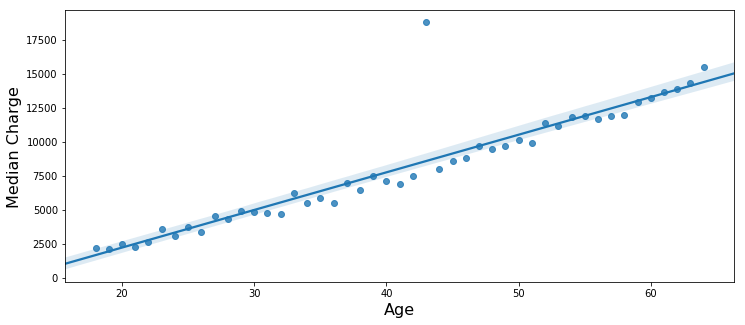

In [15]:
# Graphing Median "Charge" wrt. "Age"
%matplotlib inline

medians = []
for key, value in charge_dict.items():
    list.append(medians, [key, statistics.median(value)])

x_values = [x[0] for x in medians]
y_values = [x[1] for x in medians]

f = plt.figure(figsize=(12, 5))
sns.regplot(x_values, y_values)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Median Charge', fontsize=16)
graph = plt.show()

In [16]:
# Animate "Charge" Distribution by "Age"

def age_distribution(age):
    
    ax = plt.gca()
    ax.clear()
    
    temp = insurance[insurance['age'] == age]
    temp = temp.sort_values('charges')
    temp.reset_index(drop=True, inplace=True)
        
    sns.set(rc={'figure.figsize':(12,5)})
    sns.set_style("whitegrid", {'axes.grid' : False})
    sns.barplot(temp.index.values, temp['charges'], alpha=0.8)
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=20))

    plt.ylim(0, 60000)
    plt.xlabel('Index - Age ' + str(int(age)), fontsize=16)
    plt.ylabel('Charge', fontsize=16)

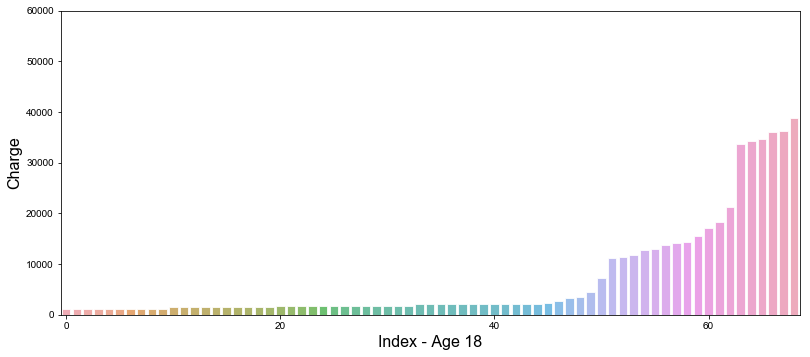

In [17]:
# Animate "Charge" Distribution by "Age"
# For some Reason, I don't think the Animation will Display outside Jupyter
%matplotlib inline

fig = plt.figure(figsize = (12,5))
fig.subplots_adjust(left=0.075, bottom=0.125, right=0.93, top=0.97, wspace=None, hspace=None)
rc('animation', html='html5')
animation.FuncAnimation(fig, age_distribution, sorted(insurance.age.unique()), interval = 1000)

This data overall does confirm my hunch--that an individual's charge does happen to increase as they age. However, it stands to reason that this doesn't occur simply because of the individual's age, but rather because they become more and more susceptible to disease and develop other physical problems that come with aging. As such, although this data does help to show this important correlation, we must also take into consideration the other factors that come into play throughout. 

In [124]:
# Exploring "Sex" Column in Dataset

sex_mappings = {0: "Male", 1: "Female"}
sex_counts = insurance['sex'].value_counts()
sex_dict = dict(sex_counts)
percentages = [
    100 * round((sex_dict[0] / (sex_dict[0] + sex_dict[1])), 3),
    100 * round((sex_dict[1] / (sex_dict[0] + sex_dict[1])), 3),
]

print("The dataset contains {} men ({}%) and {} women ({}%)".format(
    sex_dict[0], percentages[0], sex_dict[1], percentages[1]))

The dataset contains 676 men (50.5%) and 662 women (49.5%)


Initially, it looks like a pretty even spread. As shown above, there are 676 men (50.5%) and 662 women (49.5) that make up the dataset. I don't expect this feature to have too much effect on the overall patient charge, given the lack of correlation between them as shown from the plot at the beginning of the EDA. Nevertheless, it would be interesting to view the overall distribution of each sex with regards to charge.

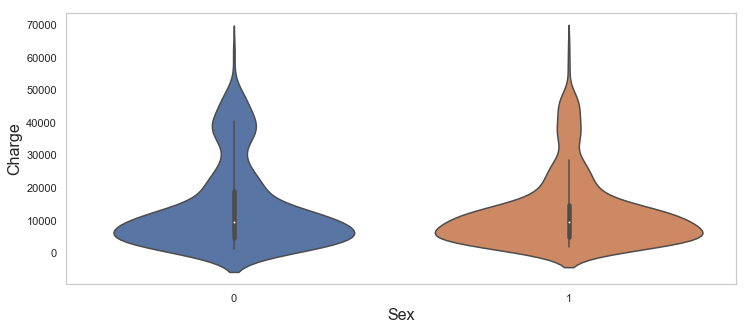

In [126]:
# Graphing "Charge" Distribution wrt. "Sex"
%matplotlib inline

x_values = insurance['sex'].values
y_values = insurance['charges'].values

f = plt.figure(figsize=(12, 5))
sns.violinplot(x_values, y_values)
plt.xlabel('Sex', fontsize=16)
plt.ylabel('Charge', fontsize=16)
graph = plt.show()

It doesn't seem like there's too much information to be gained from simply looking at sex in relation to patient charge, as there's not a discernible trend to be found. Perhaps some information can be gathered from using sex alongside other features. From the graph above, though, it is a bit interesting to note that the outliers for male patients are no less than ~40,000, whereas for females the range begins at ~30,000, however I expect that this is simply coincidental due to the small size of the dataset.

In [127]:
# Exploring "BMI" Column in Dataset

bmi_counts = insurance['bmi'].value_counts()
bmi_dict = dict(bmi_counts)

print('Most Common BMI:', max(bmi_counts.iteritems(), key=operator.itemgetter(1))[0])

Most Common BMI: 32.3


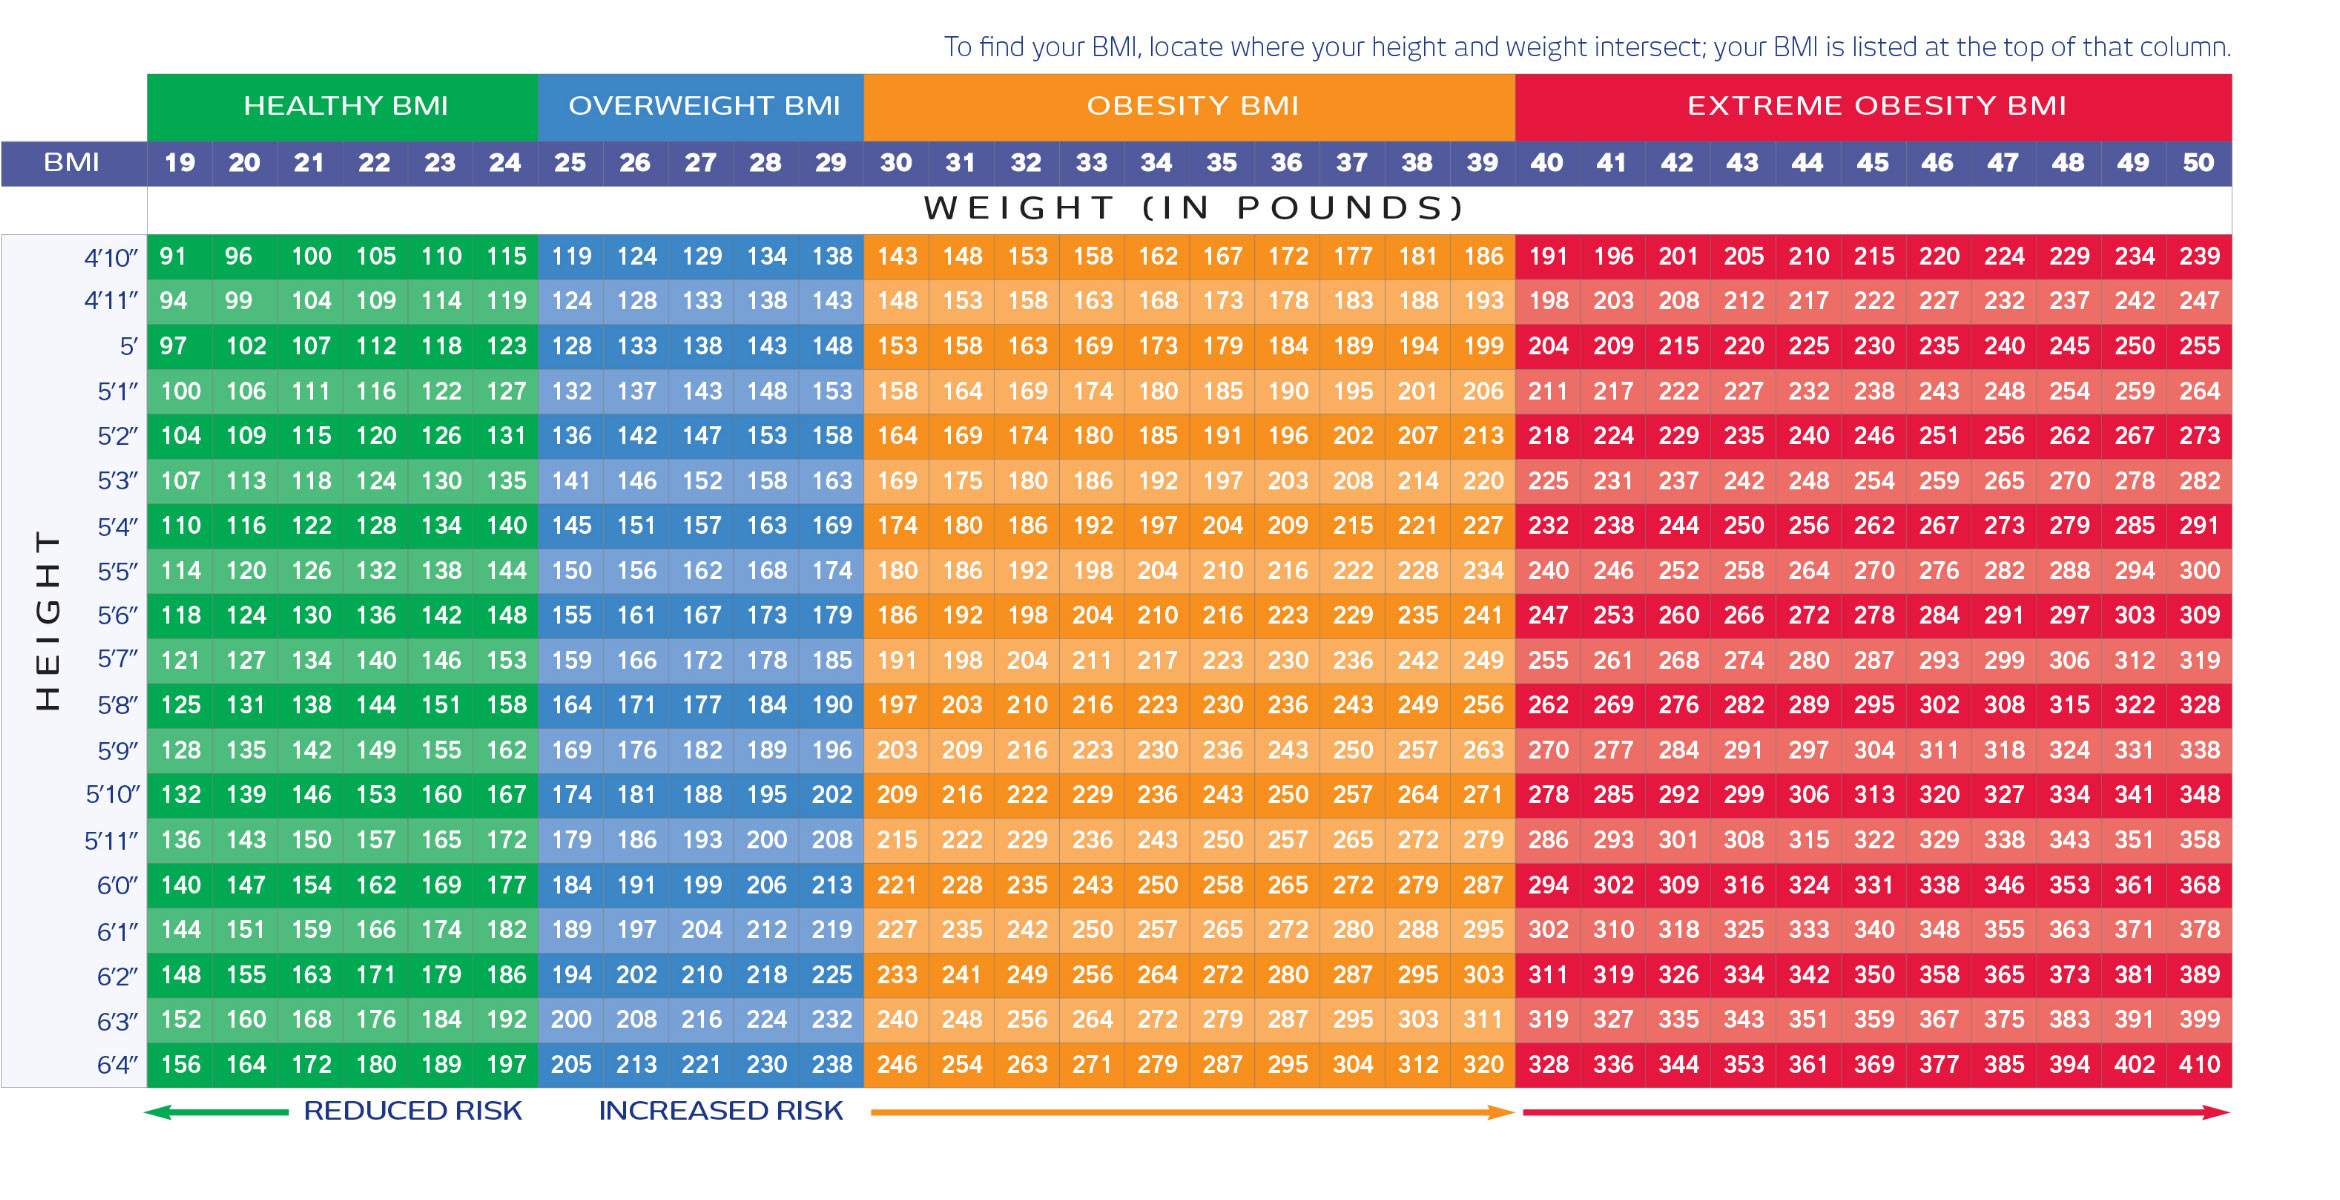

In [128]:
Image("bmi_chart.jpg")

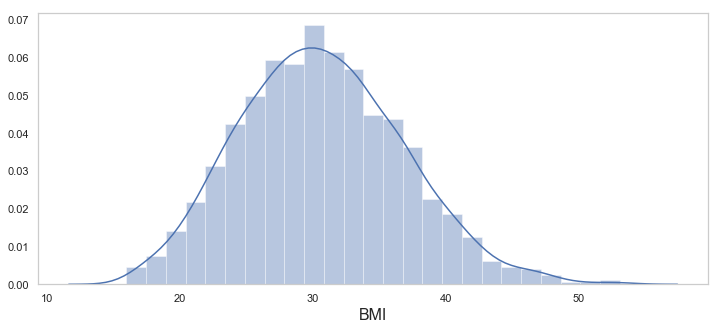

In [129]:
# Graphing "BMI" Distribution in Dataset
%matplotlib inline

f = plt.figure(figsize=(12, 5))
sns.distplot(insurance['bmi'].values)
plt.xlabel('BMI', fontsize=16)
graph = plt.show()

Overall, the BMI spread throughout the dataset seems to follow a pretty normal distribution, with the average BMI consisting of ~30. According to the chart above, a BMI of 30 corresponds to obesity, which in itself leads to other diseases and problems. As such, it'll probably be helpful to look further into the correlation between a higher BMI and charge. 

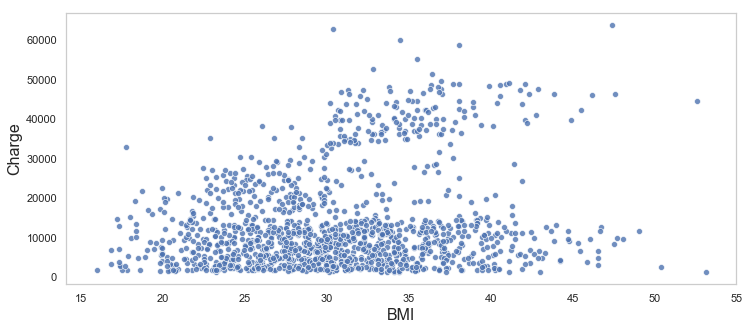

In [130]:
# Graphing "BMI" Distribution in Dataset
%matplotlib inline

x_values = insurance['bmi'].values
y_values = insurance['charges'].values

f = plt.figure(figsize=(12, 5))
sns.scatterplot(x_values, y_values, alpha=0.8)
plt.xlabel('BMI', fontsize=16)
plt.ylabel('Charge', fontsize=16)
graph = plt.show()

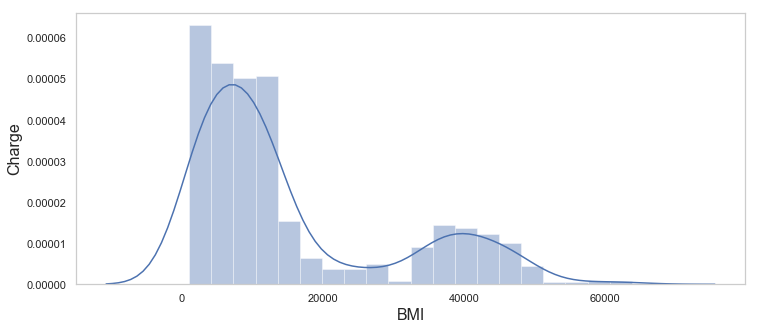

In [131]:
# Graphing "BMI" Distribution in Dataset
%matplotlib inline

insurance_bmi = insurance[insurance['bmi'] > 30]
x_values = insurance_bmi['charges'].values

f = plt.figure(figsize=(12, 5))
sns.distplot(x_values)
plt.xlabel('BMI', fontsize=16)
plt.ylabel('Charge', fontsize=16)
graph = plt.show()

Interestingly enough, there doesn't seem to be too much of an upward trend as a patient's BMI increases, although the two dense clusters of individuals with BMIs over 30 could be important. If we isolate those individuals in the dataset, maybe we can glean more information from the feature. Perhaps BMI, when combined with another feature, becomes much more indicative of a patient's final charge. 

In [132]:
# Exploring "Children" Column in Dataset

children_counts = insurance['children'].value_counts()
children_dict = dict(children_counts)
print('Most Common Number of Children:', max(children_counts.iteritems(), key=operator.itemgetter(1))[0])

Most Common Number of Children: 0


In [133]:
# Calculate "Children" wrt. "Counts"

charge_dict = {}
for index, row in insurance.iterrows():
    if row['children'] in charge_dict:
        list.append(charge_dict[row['children']], row['charges'])
    else:
        charge_dict[row['children']] = [row['charges']]

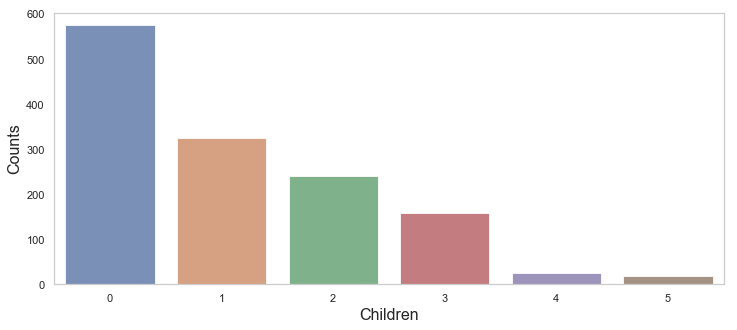

In [134]:
# Graphing "Children" Distribution in Dataset
%matplotlib inline

x_values = []
y_values = []
for key, value in charge_dict.items():
    list.append(x_values, int(key))
    list.append(y_values, len(value))

f = plt.figure(figsize=(12, 5))
sns.barplot(x_values, y_values, alpha=0.8)
plt.xlabel('Children', fontsize=16)
plt.ylabel('Counts', fontsize=16)
graph = plt.show()

This graph shows the overall distribution of children in the dataset. As expected, due to the large number of 18-19-year-olds, patients with either one or no children are the most common throughout. Perhaps this will indicate that there may also be a bit of an upward trend in average patient charge, although there doesn't seem to be much of a correlation between age and children. I don't expect this feature to be too important as a whole.

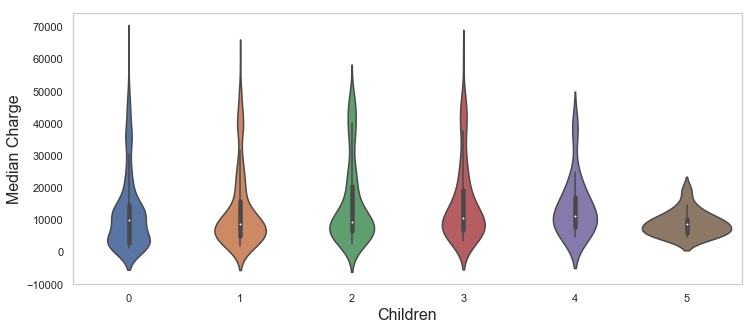

In [150]:
# Graphing Median "Charge" wrt. "Children"
%matplotlib inline

x_values = insurance['children'].values
y_values = insurance['charges'].values

f = plt.figure(figsize=(12, 5))
sns.violinplot(x_values, y_values)
plt.xlabel('Children', fontsize=16)
plt.ylabel('Median Charge', fontsize=16)
graph = plt.show()

It doesn't seem like there's too much information to be gained from simply looking at the patient's number of children in relation to patient charge, as there's not a discernible trend to be found. Perhaps some information can be gathered from using children alongside other features, such as whether or not they're a smoker. This will be explored later in the EDA.

In [158]:
# Exploring "Region" Column in Dataset

region_counts = insurance['region'].value_counts()
region_dict = dict(region_counts)

print("# of Patients Living in Southeast USA: {}".format(region_dict[0]))
print("# of Patients Living in Southwest USA: {}".format(region_dict[1]))
print("# of Patients Living in Northwest USA: {}".format(region_dict[2]))
print("# of Patients Living in Northeast USA: {}".format(region_dict[3]))

# of Patients Living in Southeast USA: 364
# of Patients Living in Southwest USA: 325
# of Patients Living in Northwest USA: 325
# of Patients Living in Northeast USA: 324


Just like with sex, there seems to be a pretty even distribution throughout the dataset, with each region of the US represented pretty much evenly. Besides this, though, I don't expect this feature to have too much effect on the overall patient charge, given the lack of correlation between them as shown from the plot at the beginning of the EDA. 

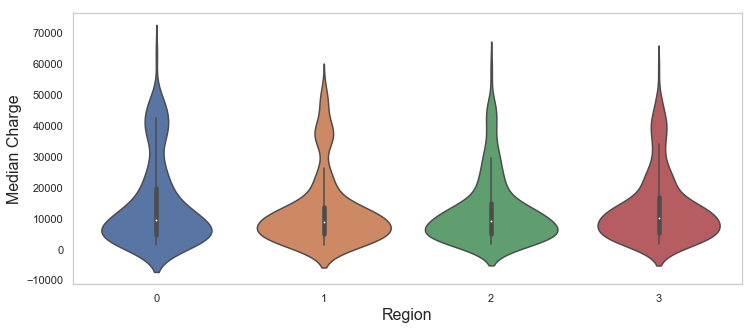

In [163]:
# Graphing "Charge" Distribution wrt. "Region"
%matplotlib inline

x_values = insurance['region'].values
y_values = insurance['charges'].values

f = plt.figure(figsize=(12, 5))
sns.violinplot(x_values, y_values)
plt.xlabel('Region', fontsize=16)
plt.ylabel('Median Charge', fontsize=16)
graph = plt.show()

By itself, there's not much information that can be gathered solely from this feature with respect to charge. Of the four possibilities, each is pretty evenly distributed, with the majority having a charge clustered around ~5,000-10,000. There might be some interesting information to be gathered from analyzing BMI and region together, however.

In [161]:
# Exploring "Region" Column in Dataset

smoker_counts = insurance['smoker'].value_counts()
smoker_dict = dict(smoker_counts)

print("# of Patients that are Smokers: {}".format(smoker_dict[1]))
print("# of Patients that are not Smokers: {}".format(smoker_dict[0]))

# of Patients that are Smokers: 274
# of Patients that are not Smokers: 1064


Solely from looking at the correlation graph, I expect this feature to be the most important in determining a patient's final charge. The fact remains that smoking is heavily responsible for a vast number of health problems, thus it's not too far-fetched to take this into consideration when looking at the dataset. As such, the first thing to look into would have to be the distribution of smokers found in the dataset with respect to their final charge.

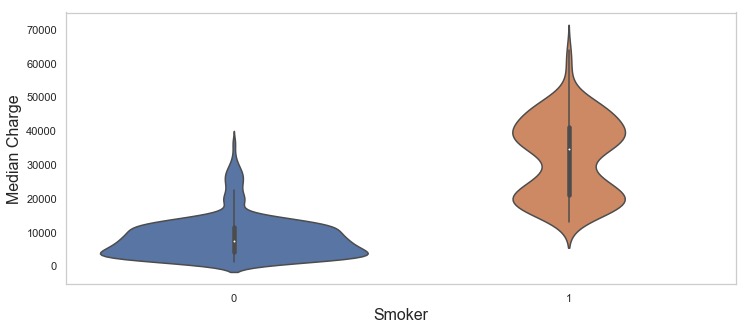

In [165]:
# Graphing "Charge" Distribution wrt. "Smoker"
%matplotlib inline

x_values = insurance['smoker'].values
y_values = insurance['charges'].values

f = plt.figure(figsize=(12, 5))
sns.violinplot(x_values, y_values)
plt.xlabel('Smoker', fontsize=16)
plt.ylabel('Median Charge', fontsize=16)
graph = plt.show()

Looking at this graph, we can easily see that my hunch was correct--being a smoker does, in fact, greatly increase your medical bills. Non-smokers far outnumber smokers in the dataset, and while their charges end up being mostly clustered around 0-10000, the simple fact that a person in this dataset smokes ensures that their bill will almost definitely be closer to the 20000-50000 range. In spite of this, as mentioned, non-smokers make up the majority of the dataset, and as such, we'll need other features to be able to accurately predict their charge.

<h3>Feature Analysis (Interactions)</h3>

This section is primarily meant to explore how each of the individual features interact with each other, specifically to see if there can be any information gathered from viewing features alongside others. Some in general: age, 'smoker', BMI, will be focused on more, as it's been found in earlier parts of the EDA that they're more closely correlated with charge throughout.

I think that I'll start by looking into the relationship between BMI and smoking, as it makes sense for each of these to have a compounding effect on the final charge, given that each comes with their own problems.

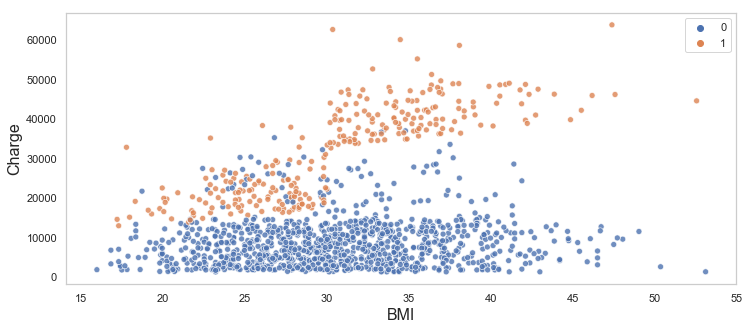

In [168]:
# Graphing "BMI"/"Smoker" Distribution in Dataset
%matplotlib inline

x_values = insurance['bmi'].values
y_values = insurance['charges'].values
z_values = insurance['smoker'].values

f = plt.figure(figsize=(12, 5))
sns.scatterplot(x_values, y_values, hue=z_values, alpha=0.8)
plt.xlabel('BMI', fontsize=16)
plt.ylabel('Charge', fontsize=16)
graph = plt.show()

This is incredibly interesting. This completely explains the two dense clusters mentioned earlier in the EDA when looking at BMI--they're split between smokers and non-smokers. In fact, it looks like there's not a single smoker with a final charge less than ~$15,000. Not only this, my hunch that BMI and smoking have a compounding effect on each other is also correct, as obese patients have a much higher charge than overweight or normal patients. Next, I'll go and break this data down by sex, to see if that feature has any effect.

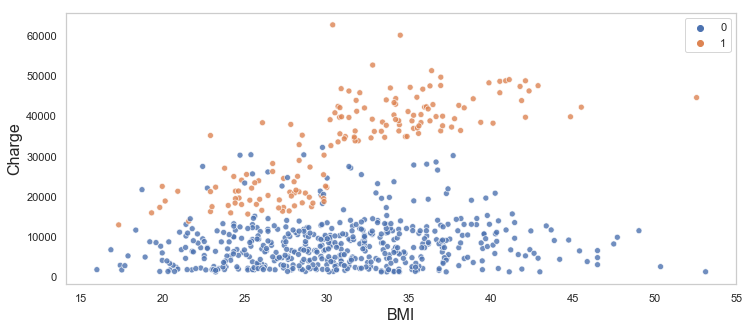

In [176]:
# Graphing "BMI"/"Smoker" Distribution in Dataset 
%matplotlib inline

insurance_male = insurance[insurance['sex'] == 0]

x_values = insurance_male['bmi'].values
y_values = insurance_male['charges'].values
z_values = insurance_male['smoker'].values

f = plt.figure(figsize=(12, 5))
sns.scatterplot(x_values, y_values, hue=z_values, alpha=0.8)
plt.xlabel('BMI', fontsize=16)
plt.ylabel('Charge', fontsize=16)
graph = plt.show()

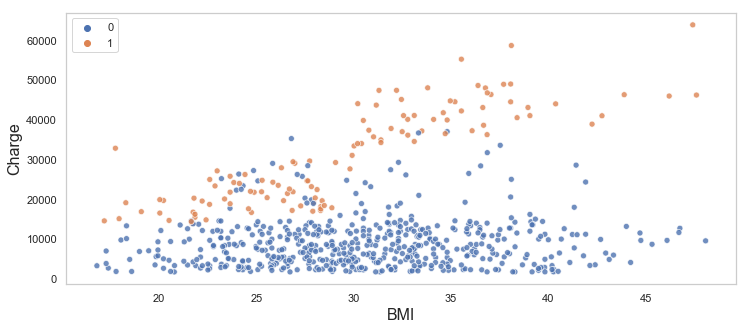

In [178]:
# Graphing "BMI"/"Smoker" Distribution in Dataset 
%matplotlib inline

insurance_female = insurance[insurance['sex'] == 1]

x_values = insurance_female['bmi'].values
y_values = insurance_female['charges'].values
z_values = insurance_female['smoker'].values

f = plt.figure(figsize=(12, 5))
sns.scatterplot(x_values, y_values, hue=z_values, alpha=0.8)
plt.xlabel('BMI', fontsize=16)
plt.ylabel('Charge', fontsize=16)
graph = plt.show()

These scatterplots are interesting, but don't seem to offer that much new information from what I can tell. It does look like charges for females are a bit more spread out than charges for males, which in turn follow a more densely populated distribution, but overall both genders seem to be rather similar as a whole regarding their final charges. It does look like smoking is perhaps the most important feature; my next foray into the data will consist of looking at an age/smoker distribution.

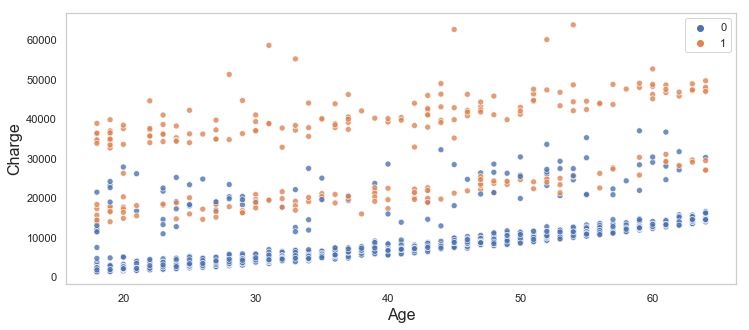

In [183]:
# Graphing "Age"/"Smoker" Distribution in Dataset
%matplotlib inline

x_values = insurance['age'].values
y_values = insurance['charges'].values
z_values = insurance['smoker'].values

f = plt.figure(figsize=(12, 5))
sns.scatterplot(x_values, y_values, hue=z_values, alpha=0.8)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Charge', fontsize=16)
graph = plt.show()

This is also really interesting. There seems to be three different types of individuals, whom each merit a different category of patient charge. 

<b>First Category:</b> Individuals whom don't smoke and seem to be relatively healthy: 2,000 - 12,000<br>
<b>Second Category:</b>  Healthier smokers and non-smoking individuals with other medical problems: 10,000 - 25,000<br>
<b>Third Category:</b> Unhealthy smokers or smokers with a host of medical problems: 30,000 - 65,000<br>

I'll next look into if each gender or BMI affects this at all.

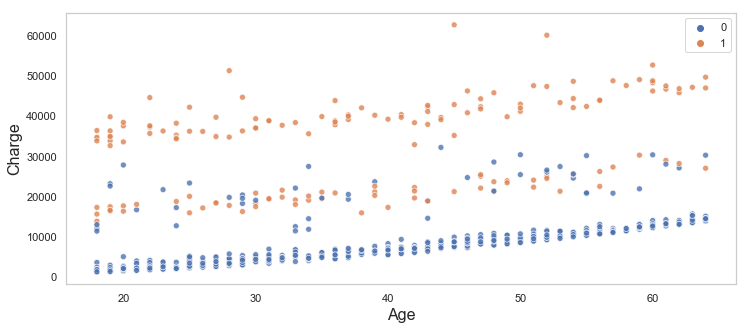

In [181]:
# Graphing "Age"/"Smoker" Distribution in Dataset
%matplotlib inline

insurance_male = insurance[insurance['sex'] == 0]

x_values = insurance_male['age'].values
y_values = insurance_male['charges'].values
z_values = insurance_male['smoker'].values

f = plt.figure(figsize=(12, 5))
sns.scatterplot(x_values, y_values, hue=z_values, alpha=0.8)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Charge', fontsize=16)
graph = plt.show()

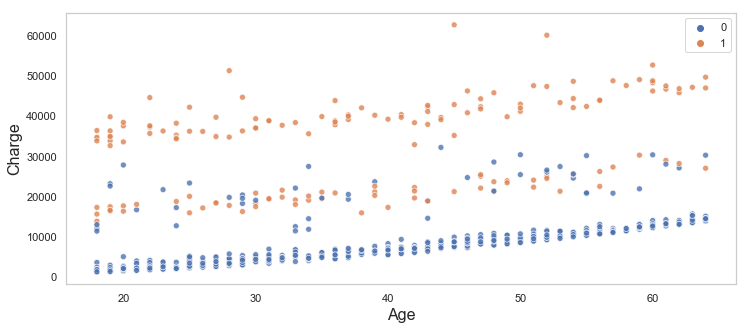

In [182]:
# Graphing "Age"/"Smoker" Distribution in Dataset
%matplotlib inline

insurance_female = insurance[insurance['sex'] == 0]

x_values = insurance_male['age'].values
y_values = insurance_male['charges'].values
z_values = insurance_male['smoker'].values

f = plt.figure(figsize=(12, 5))
sns.scatterplot(x_values, y_values, hue=z_values, alpha=0.8)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Charge', fontsize=16)
graph = plt.show()

Like with BMI, these scatterplots don't seem to offer that much new information. As such, it doesn't seem like sex ends up being too much of a factor in regards to determining a patient's final charge, which makes sense as that practice could constitute discrimination. The next thing I'll attempt would have to be separating the above graph into solely smokers, and see if their BMI comes into play as a factor in any way. 

In [234]:
def round_down(x):
    return int(math.floor(x / 10.0)) * 10

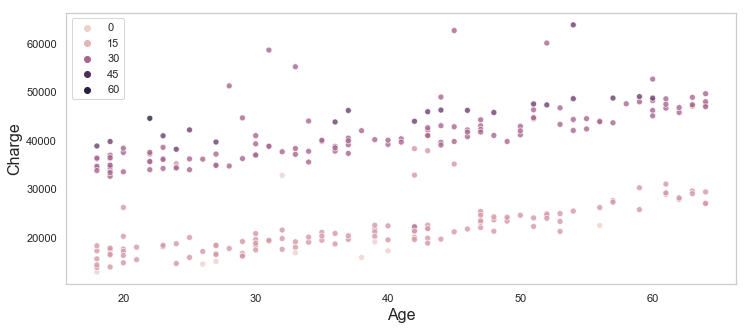

In [196]:
# Graphing "Age"/"Smoker[1]"/BMI Distribution in Dataset
%matplotlib inline

insurance_smokers = insurance[insurance['smoker'] == 1]

x_values = insurance_smokers['age'].values
y_values = insurance_smokers['charges'].values
z_values = []

for index, row in insurance_smokers.iterrows():
    list.append(z_values, round_down(row['bmi'])) 

f = plt.figure(figsize=(12, 5))
sns.scatterplot(x_values, y_values, hue=z_values, alpha=0.8)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Charge', fontsize=16)
graph = plt.show()

This is also incredibly interesting, and confirms my hunch that most smokers in the third category are also obese or heavily overweight, and as such come with other medical issues. The "healthy" smokers, those whom aren't specifically overweight, fall into the second category of individual. It could also be interesting to generate this same graph on those non-smoking individuals, to see whether or not BMI also has a factor on which category they fall into.

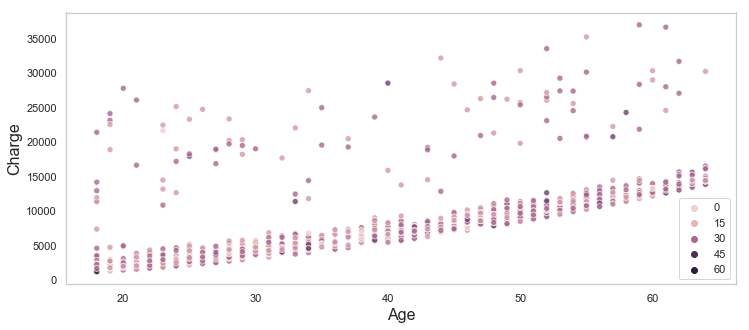

In [455]:
# Graphing "Age"/"Smoker[1]"/BMI Distribution in Dataset
%matplotlib inline

insurance_non_smokers = insurance[insurance['smoker'] == 0]

x_values = insurance_non_smokers['age'].values
y_values = insurance_non_smokers['charges'].values
z_values = []

for index, row in insurance_non_smokers.iterrows():
    list.append(z_values, round_down(row['bmi'])) 

f = plt.figure(figsize=(12, 5))
sns.scatterplot(x_values, y_values, hue=z_values, alpha=0.8)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Charge', fontsize=16)
graph = plt.show()

Unlike the smokers, there doesn't seem to be as much of a correlation between BMI and which category the individual falls into. As such, I think we can determine that while a high BMI and smoking does seem to ensure a high medical bill with the data given, it is possible to have a high BMI by itself and still be relatively healthy. 

<h3>Feature Engineering</h3>

In [297]:
# Establishing/Improving Important Features
%matplotlib inline

insurance['bmi_round_down'] = insurance['bmi'].map(lambda x: round_down(x))
insurance['age_smoker'] = pd.factorize(list(map(tuple, insurance[['age', 'smoker']].values.tolist())))[0] + 1
insurance['bmi_smoker'] = pd.factorize(list(map(tuple, insurance[['bmi_round_down', 'smoker']].values.tolist())))[0] + 1
insurance['bmi_age_smoker'] = pd.factorize(list(map(tuple, insurance[['bmi_round_down', 'age', 'smoker']].values.tolist())))[0] + 1

# Ideas from https://www.kaggle.com/janiobachmann/patient-charges-clustering-and-regression
insurance['stress'] = insurance['children'] * insurance['age'] / insurance['bmi']

Although this feature engineering isn't too extensive, it'll work pretty well for such a small dataset. All that remains now is to build a model and see how the data performs. I'll start with a simple LinearRegression to get a baseline score, and then I'll build a few more complex models and a simple stacking model to truly see how accurate I can make it, although the final possibility might be a bit overkill for this dataset.

In [383]:
# Splitting Dataset (Train, Target)

n_splits = 5
seed = 2019

train_y = insurance['charges'].values
train_x = insurance.drop('charges', axis=1)

splits = list(KFold(
    n_splits=n_splits, shuffle=True, random_state=seed).split(train_x, train_y))

<h3>Model Wrappers</h3>

In [448]:
class SklearnWrapper(object):

    def __init__(self, clf, params=None):
        self.clf = clf(**params)

    def train(self, train, target, splits, mute=False):
        
        train_preds = np.zeros((len(train)))
        for index, (train_idx, valid_idx) in enumerate(splits):
            train_x = np.array(train)[train_idx.astype(int)]
            train_y = np.array(target)[train_idx.astype(int)]
            valid_x = np.array(train)[valid_idx.astype(int)]
            valid_y = np.array(target)[valid_idx.astype(int)]
            
            self.clf.fit(train_x, train_y)
            split_preds = self.clf.predict(valid_x)
            train_preds[valid_idx] = split_preds

        if mute == False:
            print("Global Test R2: {}".format(r2_score(target, train_preds)))
            
        return train_preds
                                           
    def predict(self, x):
        return self.clf.predict(x)

<h3>First Layer Models</h3>

In [449]:
# First layer Linear Regression Model w/ Polynomial Features
# Ideas from https://www.kaggle.com/hely333/eda-regression

poly = PolynomialFeatures(degree = 2)
train_poly = poly.fit_transform(train_x)

lr_params = {}
lr_model = SklearnWrapper(clf=LinearRegression, params=lr_params)
lr_train_preds = lr_model.train(train_poly, train_y, splits).reshape(-1, 1)

Global Test R2: 0.8588144288131018


In [450]:
# First layer Random Forest Regressor Model

rf_params = {}
rf_params['n_estimators'] = 200
rf_params['max_depth'] = 4
rf_params['random_state'] = 2019

rf_model = SklearnWrapper(clf=RandomForestRegressor, params=rf_params)
rf_train_preds = rf_model.train(train_x, train_y, splits).reshape(-1, 1)

Global Test R2: 0.8572932597662587


In [451]:
# First layer Extra Trees Regressor Model

et_params = {}
et_params['n_estimators'] = 400
et_params['max_depth'] = 5
et_params['random_state'] = 2019

et_model = SklearnWrapper(clf=ExtraTreesRegressor, params=et_params)
et_train_preds = et_model.train(train_x, train_y, splits).reshape(-1, 1)

Global Test R2: 0.8616926671201335


<h3>Second Layer Models</h3>

In [452]:
# Second Layer Linear Regression Model

train_second_layer = np.concatenate((
    lr_train_preds, rf_train_preds, et_train_preds), axis=1)

lr_params = {}
second_layer_model = SklearnWrapper(clf=LinearRegression, params=lr_params)
final_preds = second_layer_model.train(train_second_layer, train_y, splits)

Global Test R2: 0.8632181006593624


<h3>Final Regression</h3>

In [454]:
# Final Regression w/ TTS

x_tra, x_te, y_tra, y_te = train_test_split(train_x, train_y, random_state = 0)
final_splits = list(KFold(n_splits=n_splits, shuffle=True, random_state=seed).split(x_tra, y_tra))

poly = PolynomialFeatures(degree = 2)
train_poly = poly.fit_transform(x_tra)
test_poly = poly.fit_transform(x_te)

lr_train_preds = lr_model.train(train_poly, y_tra, final_splits, mute=True).reshape(-1, 1)
rf_train_preds = rf_model.train(x_tra, y_tra, final_splits, mute=True).reshape(-1, 1)
et_train_preds = et_model.train(x_tra, y_tra, final_splits, mute=True).reshape(-1, 1)

lr_test_preds = lr_model.predict(test_poly).reshape(-1, 1)
rf_test_preds = rf_model.predict(x_te).reshape(-1, 1)
et_test_preds = et_model.predict(x_te).reshape(-1, 1)

train_second_layer = np.concatenate((lr_train_preds, rf_train_preds, et_train_preds), axis=1)
test_second_layer = np.concatenate((lr_test_preds, rf_test_preds, et_test_preds), axis=1)

final_train_preds = second_layer_model.train(train_second_layer, y_tra, final_splits, mute=True)
final_test_preds = second_layer_model.predict(test_second_layer)

print("Final Global Test R2: {}".format(r2_score(final_test_preds, y_te)))

Final Global Test R2: 0.8967799897178053
